In [1]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import datetime
import math
import string
import pickle
import random
import joblib
import itertools
from distutils.util import strtobool
import warnings
warnings.filterwarnings('ignore')

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/fb3-my-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/fb3-my-pip-wheels tokenizers')

import transformers
import tokenizers
print(f'transformers.__version__: {transformers.__version__}')
print(f'tokenizers.__version__: {tokenizers.__version__}')

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
os.environ['TOKENIZERS_PARALLELISM']='true'

Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1


Found existing installation: tokenizers 0.12.1
Uninstalling tokenizers-0.12.1:
  Successfully uninstalled tokenizers-0.12.1


Looking in links: ../input/fb3-my-pip-wheels
Processing /kaggle/input/fb3-my-pip-wheels/transformers-4.20.1-py3-none-any.whl
Processing /kaggle/input/fb3-my-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


Looking in links: ../input/fb3-my-pip-wheels


transformers.__version__: 4.20.1
tokenizers.__version__: 0.12.1


# Config

In [2]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
    def init(self, kwargs):
        super().init(kwargs)

        for k, v in kwargs.items():
            setattr(self, k, v)

    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

In [3]:
CFG = Config(
    str_now = datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),
    train = True,
    debug = False,
    offline = False,
    
    save_all_models = False,
    competition = 'FB3',
    apex = True,
    print_freq = 20,
    num_workers = 0,
    model = 'roberta-base', #If you want to train on the kaggle platform, v3-base is realistic. v3-large will time out.
    loss_func = 'SmoothL1', # 'SmoothL1', 'RMSE'
    max_len = 512,
    
    epochs = 3,
    n_fold = 4,
    trn_fold = (0,1,2,3),
    batch_size = 8,
    
    gradient_checkpointing = True,
    scheduler = 'cosine',
    batch_scheduler = True,
    num_cycles = 0.5,
    num_warmup_steps = 0,
    encoder_lr = 2e-5,
    decoder_lr = 2e-5,
    min_lr = 1e-6,
    
    # llrd
    llrd = True,
    layerwise_lr = 1e-5,
    layerwise_lr_decay = 0.9,
    layerwise_weight_decay = 0.01,
    layerwise_adam_epsilon = 1e-6,
    layerwise_use_bertadam = False,
    weight_decay = 0.01,
    eps = 1e-6,
    betas = (0.9, 0.999),
    
    # pooling
    pooling = 'attention4', # mean, max, min, attention, weightedlayer
    layer_start = 4,
    
    # weight init
    init_weight = 'normal', # normal, xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal, orthogonal
    
    # reinit layers
    reinit = True,
    reinit_n = 1,
    
    # adversarial
    fgm = True,
    awp = False,
    adv_lr = 1,
    adv_eps = 0.2,
    
    # gradient
    unscale = False,
    gradient_accumulation_steps = 1,
    max_grad_norm = 1000,
    target_cols = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'],
    
    seed = 42,
    cv_seed = 42,
    n_targets = 6,
    
    #gpu_id = 0,
    #device = f'cuda:{gpu_id}',
    device = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu')),
    train_file = '../input/feedback-prize-english-language-learning/train.csv',
    test_file = '../input/feedback-prize-english-language-learning/test.csv',
    submission_file = '../input/feedback-prize-english-language-learning/sample_submission.csv')

In [4]:
#Unique model name
if len(CFG.model.split("/")) == 2:
    CFG.identifier = f'{CFG.str_now}-{CFG.model.split("/")[1]}'
else:
    CFG.identifier = f'{CFG.str_now}-{CFG.model}'
    
print(CFG.identifier)

20221121-173739-roberta-base


# Data splits

In [5]:
CFG.output_dir = f'./{CFG.identifier}/'
CFG.log_filename = CFG.output_dir + 'train'

os.makedirs(CFG.output_dir, exist_ok=True)    

cfg_json = json.dumps(CFG)
with open(os.path.join(CFG.output_dir, 'CFG.json'), 'w') as f:
    f.write(cfg_json)

In [6]:
CFG.df_train = pd.read_csv(CFG.train_file)

mskfold = MultilabelStratifiedKFold(n_splits = CFG.n_fold, shuffle = True, random_state = CFG.cv_seed)
for n, (train_index, val_index) in enumerate(mskfold.split(CFG.df_train, CFG.df_train[CFG.target_cols])):
    CFG.df_train.loc[val_index, 'fold'] = int(n)
CFG.df_train['fold'] = CFG.df_train['fold'].astype(int)

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    if CFG.train:
        CFG.df_train = CFG.df_train.sample(n = 100, random_state = CFG.seed).reset_index(drop=True)

# Helper function

In [7]:
def mcrmse(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:, i]
        y_pred = y_preds[:, i]
        score = mean_squared_error(y_true, y_pred, squared = False)
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores

def get_score(y_trues, y_preds):
    mcrmse_score, scores = mcrmse(y_trues, y_preds)
    return mcrmse_score, scores

def get_logger(filename = CFG.log_filename):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter('%(message)s'))
    handler2 = FileHandler(filename = f'{filename}.log')
    handler2.setFormatter(Formatter('%(message)s'))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text,
        return_tensors = None,
        add_special_tokens = True,
        max_length = cfg.max_len,
        pad_to_max_length = True,
        truncation = True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype = torch.long)
    return inputs    

def collate(inputs):
    mask_len = int(inputs['attention_mask'].sum(axis = 1).max())
        
    for k, v in inputs.items():
        inputs[k] = inputs[k][:, :mask_len]
    return inputs

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.history = []

    def update(self, val, n=1):
        self.val = val
        self.history.append(val)
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{str(int(m)).zfill(2)}:{str(int(s)).zfill(2)}'

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{str(asMinutes(s))}<{str(asMinutes(rs))}'

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
class RMSELoss(nn.Module):
    def __init__(self, reduction = 'mean', eps = 1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction = 'none')
        self.reduction = reduction
        self.eps = eps
        
    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss
    
seed_everything(CFG.seed)

# Pooling

# Fast Gradient Method (FGM)
Reference :

https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143764

In [8]:
class FGM():
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon = 1., emb_name = 'word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0:
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name = 'word_embeddings'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                assert name in self.backup
                param.data = self.backup[name]
            self.backup = {}


# Adversarial Weight Perturbation (AWP)
There may be a bug in my implementation because it does not work well.

Reference : 

https://www.kaggle.com/code/wht1996/feedback-nn-train/notebook

In [9]:
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler
        
    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()
        
    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

# Train function

In [10]:
def train_one_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    losses = AverageMeter()
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled = CFG.apex)
    start = end = time.time()
    global_step = 0
    
    if CFG.fgm:
        fgm = FGM(model)
    if CFG.awp:
        awp = AWP(
            model,
            optimizer,
            adv_lr = CFG.adv_lr, 
            adv_eps = CFG.adv_eps, 
            scaler = scaler)
        
    for step, (inputs, labels) in enumerate(train_loader):
        attention_mask = inputs['attention_mask'].to(device)
          #inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        with torch.cuda.amp.autocast(enabled = CFG.apex):
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        
        #Fast Gradient Method (FGM)
        if CFG.fgm:
            fgm.attack()
            with torch.cuda.amp.autocast(enabled = CFG.apex):
                y_preds = model(inputs)
                loss_adv = criterion(y_preds, labels)
                loss_adv.backward()
            fgm.restore()
            
        #Adversarial Weight Perturbation (AWP)
        if CFG.awp:
            loss_awp = awp.attack_backward(inputs, labels, attention_mask, step + 1)
            loss_awp.backward()
            awp._restore()
        
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.unscale:
                scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('>>> [TRAIN] Epoch {0}: {1}/{2} [{remain:s}]  loss:{loss.val:.4f}({loss.avg:.4f});    grad:{grad_norm:.4f};    lr:{lr:.8f}'.format(
                epoch+1, 
                step,
                len(train_loader),
                remain = timeSince(start, float(step + 1)/len(train_loader)),
                loss = losses,
                grad_norm = grad_norm,
                lr = scheduler.get_lr()[0]))
        del inputs, labels, y_preds; gc.collect(); torch.cuda.empty_cache();
        
        #print(torch.cuda.memory_allocated())
    
    ax = pd.DataFrame(losses.history, columns=['train_loss']).plot()
    ax.set_title(f'fold{fold}  epoch{epoch}')
    plt.show()
    
    return losses

# Valid function

In [11]:
def validate(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
            
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('>>> [EVAL] {0}/{1} [{remain:s}]   loss: {loss.val:.4f}({loss.avg:.4f})'.format(
                step+1, 
                len(valid_loader),
                loss = losses,
                remain = timeSince(start, float(step + 1) / len(valid_loader))))
    return losses.avg, np.concatenate(preds)

# Plot metrics

In [12]:
def plot_metrics(df):
    f, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    
    df[['val_loss', 'train_loss']].plot(ax=ax[0])
    df[['mcrmse'] + CFG.target_cols].plot(ax=ax[1])

    plt.show()
    return f

# Logger

In [13]:
logger = get_logger()
logger.info(f'output_dir: {CFG.output_dir}')

output_dir: ./20221121-173739-roberta-base/


# Tokenizer

In [14]:
CFG.tokenizer = AutoTokenizer.from_pretrained(CFG.model)
CFG.tokenizer.save_pretrained(CFG.output_dir + 'tokenizer')

#max_len
lengths = []
tk0 = tqdm(CFG.df_train['full_text'].fillna('').values, total = len(CFG.df_train))
for text in tk0:
    length = len(CFG.tokenizer(text, add_special_tokens = False)['input_ids'])
    lengths.append(length)
# CFG.max_len = max(lengths) + 2
CFG.max_len = 512
logger.info(f'max_len: {CFG.max_len}')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/3911 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
max_len: 512


# Dataset

In [15]:
class FB3TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df[cfg.target_cols].values
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype = torch.float)
        return inputs, label

# Model

* Initializing module (normal, xavier_uniform, xavier_normal, kaiming_uniform, kaiming_normal, orthogonal) 
* Freeze lower layer when you use large model (v2-xlarge, funnnel, etc.)

In [16]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min = 1e-9)
        mean_embeddings = sum_embeddings/sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim = 1)
        return max_embeddings
    
class MinPooling(nn.Module):
    def __init__(self):
        super(MinPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = 1e-4
        min_embeddings, _ = torch.min(embeddings, dim = 1)
        return min_embeddings

#Attention pooling
class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(
        nn.Linear(in_dim, in_dim),
        nn.LayerNorm(in_dim),
        nn.GELU(),
        nn.Linear(in_dim, 1),
        )

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings
    
class AttentionHead(nn.Module):
    def __init__(self, h_size, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(h_size, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, ft_all_layers):
        all_layer_embedding = torch.stack(ft_all_layers)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]

        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

        return weighted_average

In [17]:
class FB3Model(nn.Module):
    def __init__(self, CFG, config_path = None, pretrained = False):
        super().__init__()
        self.CFG = CFG
        if config_path is None:
            self.config = AutoConfig.from_pretrained(CFG.model, output_hidden_states = True)
            self.config.save_pretrained(CFG.output_dir + 'config')
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            self.config.layer_norm_eps = 1e-7
        else:
            self.config = torch.load(config_path)
            
        logger.info(self.config)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(CFG.model, config=self.config)
            self.model.save_pretrained(CFG.output_dir + 'model')
        else:
            self.model = AutoModel(self.config)
            
        if self.CFG.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
            
        if CFG.pooling == 'mean':
            self.pool = MeanPooling()
        elif CFG.pooling == 'max':
            self.pool = MaxPooling()
        elif CFG.pooling == 'min':
            self.pool = MinPooling()
        elif CFG.pooling == 'attention':
            self.pool = AttentionPooling(self.config.hidden_size)
        elif CFG.pooling == 'attention4':
            self.pool = AttentionHead(self.config.hidden_size*4)
        elif CFG.pooling == 'weightedlayer':
            self.pool = WeightedLayerPooling(self.config.num_hidden_layers, layer_start = CFG.layer_start, layer_weights = None)
        
        if CFG.pooling == 'attention4':
            self.fc = nn.Linear(self.config.hidden_size*8, self.CFG.n_targets)
        else:
            self.fc = nn.Linear(self.config.hidden_size, self.CFG.n_targets)
        self._init_weights(self.fc)
        
        if 'deberta-v2-xxlarge' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.layer[:24].requires_grad_(False)
        if 'deberta-v2-xlarge' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.layer[:12].requires_grad_(False)
        if 'funnel-transformer-xlarge' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.blocks[:1].requires_grad_(False)
        if 'funnel-transformer-large' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.blocks[:1].requires_grad_(False)
        if 'deberta-large' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.layer[:16].requires_grad_(False)
        if 'deberta-xlarge' in CFG.model:
            self.model.embeddings.requires_grad_(False)
            self.model.encoder.layer[:36].requires_grad_(False)
            
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            if CFG.init_weight == 'normal':
                module.weight.data.normal_(mean = 0.0, std = self.config.initializer_range)
            elif CFG.init_weight == 'xavier_uniform':
                module.weight.data = nn.init.xavier_uniform_(module.weight.data)
            elif CFG.init_weight == 'xavier_normal':
                module.weight.data = nn.init.xavier_normal_(module.weight.data)
            elif CFG.init_weight == 'kaiming_uniform':
                module.weight.data = nn.init.kaiming_uniform_(module.weight.data)
            elif CFG.init_weight == 'kaiming_normal':
                module.weight.data = nn.init.kaiming_normal_(module.weight.data)
            elif CFG.init_weight == 'orthogonal':
                module.weight.data = nn.init.orthogonal_(module.weight.data)
                
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            if CFG.init_weight == 'normal':
                module.weight.data.normal_(mean = 0.0, std = self.config.initializer_range)
            elif CFG.init_weight == 'xavier_uniform':
                module.weight.data = nn.init.xavier_uniform_(module.weight.data)
            elif CFG.init_weight == 'xavier_normal':
                module.weight.data = nn.init.xavier_normal_(module.weight.data)
            elif CFG.init_weight == 'kaiming_uniform':
                module.weight.data = nn.init.kaiming_uniform_(module.weight.data)
            elif CFG.init_weight == 'kaiming_normal':
                module.weight.data = nn.init.kaiming_normal_(module.weight.data)
            elif CFG.init_weight == 'orthogonal':
                module.weight.data = nn.init.orthogonal_(module.weight.data)
                
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def feature(self, inputs):
        outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        if CFG.pooling == 'attention4':
            all_layer_embeddings = torch.stack(outputs.hidden_states)
            cat_over_last_layers = torch.cat((all_layer_embeddings[-1], all_layer_embeddings[-2], all_layer_embeddings[-3], all_layer_embeddings[-4]), -1)
            cls_pooling = cat_over_last_layers[:, 0]
            head_logits = self.pool(cat_over_last_layers)
            feature = torch.cat([head_logits, cls_pooling], -1)
        elif CFG.pooling != 'weightedlayer':
            last_hidden_states = outputs[0]
            feature = self.pool(last_hidden_states, inputs['attention_mask'])
        
        else:
            all_layer_embeddings = outputs[1]
            feature = self.pool(all_layer_embeddings)
            
        return feature
    
    def forward(self, inputs):
        feature = self.feature(inputs)
        outout = self.fc(feature)
        return outout

# Train

In [18]:
def re_initializing_layer(model, config, layer_num):
    for module in model.model.encoder.layer[-layer_num:].modules():
        if isinstance(module, nn.Linear):

            if CFG.init_weight == 'normal':
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
            elif CFG.init_weight == 'xavier_uniform':
                module.weight.data = nn.init.xavier_uniform_(module.weight.data)
            elif CFG.init_weight == 'xavier_normal':
                module.weight.data = nn.init.xavier_normal_(module.weight.data)
            elif CFG.init_weight == 'kaiming_uniform':
                module.weight.data = nn.init.kaiming_uniform_(module.weight.data)
            elif CFG.init_weight == 'kaiming_normal':
                module.weight.data = nn.init.kaiming_normal_(module.weight.data)
            elif CFG.init_weight == 'orthogonal':
                module.weight.data = nn.init.orthogonal_(module.weight.data) 
                
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            if CFG.init_weight == 'normal':
                module.weight.data.normal_(mean=0.0, std=config.initializer_range)
            elif CFG.init_weight == 'xavier_uniform':
                module.weight.data = nn.init.xavier_uniform_(module.weight.data)
            elif CFG.init_weight == 'xavier_normal':
                module.weight.data = nn.init.xavier_normal_(module.weight.data)
            elif CFG.init_weight == 'kaiming_uniform':
                module.weight.data = nn.init.kaiming_uniform_(module.weight.data)
            elif CFG.init_weight == 'kaiming_normal':
                module.weight.data = nn.init.kaiming_normal_(module.weight.data)
            elif CFG.init_weight == 'orthogonal':
                module.weight.data = nn.init.orthogonal_(module.weight.data)
                
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    return model   

def train_loop(folds, fold):
    logger.info(f"========== fold: {fold} training ==========")
    
    train_folds = folds[folds['fold'] != fold].reset_index(drop = True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop = True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = FB3TrainDataset(CFG, train_folds)
    valid_dataset = FB3TrainDataset(CFG, valid_folds)
    
    train_loader = DataLoader(train_dataset,
                              batch_size = CFG.batch_size,
                              shuffle = True, 
                              num_workers = CFG.num_workers,
                              pin_memory = True, 
                              drop_last = True
                             )
    valid_loader = DataLoader(valid_dataset,
                              batch_size = CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers,
                              pin_memory=True, 
                              drop_last=False)

    model = FB3Model(CFG, config_path = None, pretrained = True)
    if CFG.reinit:
        model = re_initializing_layer(model, model.config, CFG.reinit_n)
        
    #os.makedirs(CFG.output_dir + 'config/', exist_ok = True)
    #torch.save(model.config, CFG.output_dir + 'config/config.pth')
    model.to(CFG.device)
    
    def get_optimizer_params(model,
                             encoder_lr,
                             decoder_lr,
                             weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr,
             'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr,
             'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr,
             'weight_decay': 0.0}
        ]
        return optimizer_parameters
    
    #llrd
    def get_optimizer_grouped_parameters(model):
        named_parameters = list(model.named_parameters())    
    
        if CFG.model == 'roberta-large':
            roberta_parameters = named_parameters[:389]    
            attention_parameters = named_parameters[391:395]
            regressor_parameters = named_parameters[395:]
        elif CFG.model == 'roberta-base':
            roberta_parameters = named_parameters[:197]    
            attention_parameters = named_parameters[199:203]
            regressor_parameters = named_parameters[203:]

        attention_group = [params for (name, params) in attention_parameters]
        regressor_group = [params for (name, params) in regressor_parameters]

        parameters = []
        parameters.append({"params": attention_group})
        parameters.append({"params": regressor_group})
        # increase lr every second layer
        increase_lr_every_k_layer = 1
        lrs = np.linspace(1, 5, 24 // increase_lr_every_k_layer)
        for layer_num, (name, params) in enumerate(roberta_parameters):
            weight_decay = 0.0 if "bias" in name else 0.01
            splitted_name = name.split('.')
            lr = CFG.layerwise_lr
            if len(splitted_name) >= 4 and str.isdigit(splitted_name[3]):
                layer_num = int(splitted_name[3])
                lr = lrs[layer_num // increase_lr_every_k_layer] * CFG.layerwise_lr

            parameters.append({"params": params,
                               "weight_decay": weight_decay,
                               "lr": lr})

        return parameters
    
    if CFG.llrd:
        from transformers import AdamW
        grouped_optimizer_params = get_optimizer_grouped_parameters(model)
        optimizer = AdamW(grouped_optimizer_params,
                          lr = CFG.layerwise_lr,
                          eps = CFG.layerwise_adam_epsilon,
                          correct_bias = not CFG.layerwise_use_bertadam)
    else:
        from torch.optim import AdamW
        optimizer_parameters = get_optimizer_params(model,
                                                    encoder_lr=CFG.encoder_lr, 
                                                    decoder_lr=CFG.decoder_lr,
                                                    weight_decay=CFG.weight_decay)
        optimizer = AdamW(optimizer_parameters, 
                          lr=CFG.encoder_lr,
                          eps=CFG.eps,
                          betas=CFG.betas)
    
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps = cfg.num_warmup_steps, 
                num_training_steps = num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, 
                num_warmup_steps = cfg.num_warmup_steps, 
                num_training_steps = num_train_steps,
                num_cycles = cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)
    
    if CFG.loss_func == 'SmoothL1':
        criterion = nn.SmoothL1Loss(reduction='mean')
    elif CFG.loss_func == 'RMSE':
        criterion = RMSELoss(reduction='mean')
    
    best_score = np.inf
    best_train_loss = np.inf
    best_val_loss = np.inf
    
    epoch_list = []
    epoch_avg_loss_list = []
    epoch_avg_val_loss_list = []
    epoch_score_list = []
    epoch_scores_list = []

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        train_loss = train_one_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        avg_train_loss = train_loss.avg
        
        # eval
        avg_val_loss, predictions = validate(valid_loader, model, criterion, CFG.device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time
        
        logger.info('====================================================')
        logger.info(f'>>> Epoch {epoch+1} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        logger.info(f'>>> Epoch {epoch+1} - score: {score:.4f}  scores: {scores}')
        
        
        epoch_list.append(epoch+1)
        epoch_avg_loss_list.append(avg_train_loss)
        epoch_avg_val_loss_list.append(avg_val_loss)
        epoch_score_list.append(score)
        epoch_scores_list.append(scores)
        
        if best_score > score:
            best_score = score
            best_train_loss = avg_train_loss
            best_val_loss = avg_val_loss
            logger.info(f'>>> 🌟🌟🌟🌟🌟 new best_score: {best_score:.4f}')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        CFG.output_dir + f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        logger.info('====================================================')
        print('\n')
        
        if CFG.save_all_models:
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        CFG.output_dir + f"{CFG.model.replace('/', '-')}_fold{fold}_epoch{epoch + 1}.pth")

    predictions = torch.load(CFG.output_dir + f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location = torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    
    df_epoch = pd.DataFrame({'epoch' : epoch_list,
                             'mcrmse' : epoch_score_list,
                             'train_loss' : epoch_avg_loss_list, 
                             'val_loss' : epoch_avg_val_loss_list})
    df_scores = pd.DataFrame(epoch_scores_list)
    df_scores.columns = CFG.target_cols
    history = pd.concat([df_epoch, df_scores], axis = 1)
    
    # Plots.
    f = plot_metrics(history)
    f.savefig(os.path.join(CFG.output_dir, f'fold{fold}_metrics.png'), dpi=300)
    history['fold'] = fold
    
    f = pd.DataFrame(train_loss.history, columns=['train_loss']).plot().get_figure()
    f.savefig(os.path.join(CFG.output_dir, f'fold{fold}_train_loss.png'), dpi=300)
    plt.show()
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return best_train_loss, best_val_loss, valid_folds, history

========== fold: 0 training ==========
RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


>>> [TRAIN] Epoch 1: 0/366 [00:02<14:20]  loss:2.2251(2.2251);    grad:inf;    lr:0.00001000
>>> [TRAIN] Epoch 1: 20/366 [00:30<08:22]  loss:0.3194(1.0548);    grad:290882.3125;    lr:0.00000999
>>> [TRAIN] Epoch 1: 40/366 [00:59<07:47]  loss:0.1223(0.6586);    grad:95593.0312;    lr:0.00000997
>>> [TRAIN] Epoch 1: 60/366 [01:27<07:16]  loss:0.2339(0.5041);    grad:85665.9844;    lr:0.00000992
>>> [TRAIN] Epoch 1: 80/366 [01:55<06:46]  loss:0.1768(0.4136);    grad:59523.5664;    lr:0.00000987
>>> [TRAIN] Epoch 1: 100/366 [02:23<06:16]  loss:0.1140(0.3605);    grad:88484.7891;    lr:0.00000979
>>> [TRAIN] Epoch 1: 120/366 [02:51<05:48]  loss:0.1251(0.3236);    grad:77938.7812;    lr:0.00000970
>>> [TRAIN] Epoch 1: 140/366 [03:20<05:19]  loss:0.1196(0.2958);    grad:52942.3047;    lr:0.00000960
>>> [TRAIN] Epoch 1: 160/366 [03:48<04:50]  loss:0.1370(0.2788);    grad:53322.9961;    lr:0.00000948
>>> [TRAIN] Epoch 1: 180/366 [04:16<04:22]  loss:0.1262(0.2642);    grad:101807.3516;    lr:0.

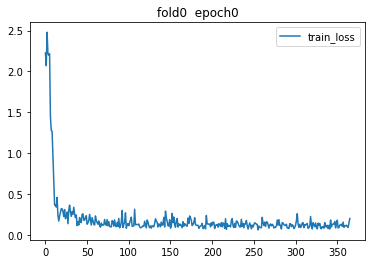

>>> [EVAL] 1/62 [00:00<00:18]   loss: 0.1013(0.1013)
>>> [EVAL] 21/62 [00:06<00:12]   loss: 0.1014(0.1231)
>>> [EVAL] 41/62 [00:12<00:06]   loss: 0.0895(0.1227)


>>> Epoch 1 - avg_train_loss: 0.1928  avg_val_loss: 0.1232  time: 537s
>>> Epoch 1 - score: 0.4970  scores: [0.5122660374048454, 0.5678100645574988, 0.44385759041654765, 0.4677380747975239, 0.49310155865453337, 0.49728720326691966]
>>> 🌟🌟🌟🌟🌟 new best_score: 0.4970


>>> [EVAL] 61/62 [00:18<00:00]   loss: 0.1133(0.1232)
>>> [EVAL] 62/62 [00:18<00:00]   loss: 0.1294(0.1232)




>>> [TRAIN] Epoch 2: 0/366 [00:01<07:11]  loss:0.0870(0.0870);    grad:inf;    lr:0.00000749
>>> [TRAIN] Epoch 2: 20/366 [00:29<08:02]  loss:0.0920(0.1225);    grad:147333.6250;    lr:0.00000724
>>> [TRAIN] Epoch 2: 40/366 [00:57<07:36]  loss:0.0868(0.1178);    grad:120604.2109;    lr:0.00000698
>>> [TRAIN] Epoch 2: 60/366 [01:25<07:09]  loss:0.0488(0.1109);    grad:48336.1523;    lr:0.00000672
>>> [TRAIN] Epoch 2: 80/366 [01:54<06:41]  loss:0.1248(0.1081);    grad:184683.5000;    lr:0.00000644
>>> [TRAIN] Epoch 2: 100/366 [02:22<06:13]  loss:0.1146(0.1075);    grad:146720.6562;    lr:0.00000617
>>> [TRAIN] Epoch 2: 120/366 [02:50<05:45]  loss:0.0581(0.1068);    grad:87277.2422;    lr:0.00000589
>>> [TRAIN] Epoch 2: 140/366 [03:19<05:18]  loss:0.0822(0.1075);    grad:58088.1562;    lr:0.00000561
>>> [TRAIN] Epoch 2: 160/366 [03:47<04:49]  loss:0.0650(0.1064);    grad:50674.9688;    lr:0.00000532
>>> [TRAIN] Epoch 2: 180/366 [04:15<04:21]  loss:0.1238(0.1067);    grad:146812.5469;    

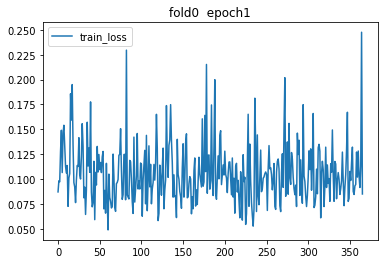

>>> [EVAL] 1/62 [00:00<00:18]   loss: 0.0791(0.0791)
>>> [EVAL] 21/62 [00:06<00:12]   loss: 0.0792(0.1055)
>>> [EVAL] 41/62 [00:12<00:06]   loss: 0.0755(0.1061)


>>> Epoch 2 - avg_train_loss: 0.1059  avg_val_loss: 0.1071  time: 534s
>>> Epoch 2 - score: 0.4635  scores: [0.4906004693706389, 0.4560643794744097, 0.4240982238655886, 0.45522071863221436, 0.4836794993818112, 0.47155968251437413]
>>> 🌟🌟🌟🌟🌟 new best_score: 0.4635


>>> [EVAL] 61/62 [00:18<00:00]   loss: 0.0910(0.1070)
>>> [EVAL] 62/62 [00:18<00:00]   loss: 0.1392(0.1071)




>>> [TRAIN] Epoch 3: 0/366 [00:01<07:17]  loss:0.0908(0.0908);    grad:inf;    lr:0.00000250
>>> [TRAIN] Epoch 3: 20/366 [00:29<08:03]  loss:0.1107(0.0948);    grad:229866.4062;    lr:0.00000225
>>> [TRAIN] Epoch 3: 40/366 [00:57<07:35]  loss:0.0739(0.0998);    grad:337128.4062;    lr:0.00000202
>>> [TRAIN] Epoch 3: 60/366 [01:25<07:08]  loss:0.1365(0.0992);    grad:244737.9844;    lr:0.00000179
>>> [TRAIN] Epoch 3: 80/366 [01:53<06:40]  loss:0.1288(0.0974);    grad:110750.7969;    lr:0.00000158
>>> [TRAIN] Epoch 3: 100/366 [02:21<06:12]  loss:0.1002(0.0978);    grad:138876.5312;    lr:0.00000138
>>> [TRAIN] Epoch 3: 120/366 [02:49<05:43]  loss:0.0909(0.0959);    grad:59067.0664;    lr:0.00000119
>>> [TRAIN] Epoch 3: 140/366 [03:18<05:15]  loss:0.1017(0.0955);    grad:60974.1641;    lr:0.00000101
>>> [TRAIN] Epoch 3: 160/366 [03:46<04:47]  loss:0.0730(0.0956);    grad:95599.8750;    lr:0.00000084
>>> [TRAIN] Epoch 3: 180/366 [04:14<04:19]  loss:0.1138(0.0954);    grad:83229.0078;    

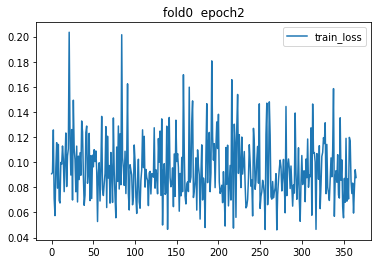

>>> [EVAL] 1/62 [00:00<00:19]   loss: 0.0664(0.0664)
>>> [EVAL] 21/62 [00:06<00:12]   loss: 0.0757(0.0983)
>>> [EVAL] 41/62 [00:12<00:06]   loss: 0.0814(0.1000)


>>> Epoch 3 - avg_train_loss: 0.0941  avg_val_loss: 0.1015  time: 533s
>>> Epoch 3 - score: 0.4508  scores: [0.482026504623507, 0.4410845229127203, 0.41218918058150855, 0.4582273050676872, 0.47180778833734444, 0.4396004998338964]
>>> 🌟🌟🌟🌟🌟 new best_score: 0.4508


>>> [EVAL] 61/62 [00:18<00:00]   loss: 0.0869(0.1013)
>>> [EVAL] 62/62 [00:18<00:00]   loss: 0.1917(0.1015)


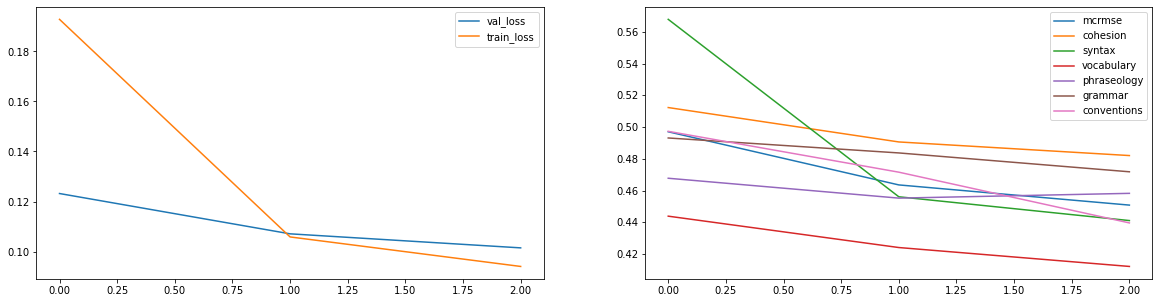

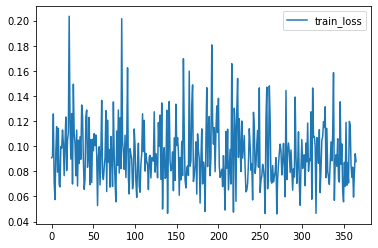

========== Fold 0 result ==========
Score: 0.4508  Scores: [0.482026504623507, 0.4410845229127203, 0.41218918058150855, 0.4582273050676872, 0.47180778833734444, 0.4396004998338964]
========== fold: 1 training ==========
RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

Some weights of the model checkpoint

>>> [TRAIN] Epoch 1: 0/366 [00:01<07:17]  loss:2.9355(2.9355);    grad:inf;    lr:0.00001000
>>> [TRAIN] Epoch 1: 20/366 [00:29<08:00]  loss:0.5344(1.6338);    grad:187003.4219;    lr:0.00000999
>>> [TRAIN] Epoch 1: 40/366 [00:57<07:34]  loss:0.2142(0.9784);    grad:96399.9062;    lr:0.00000997
>>> [TRAIN] Epoch 1: 60/366 [01:25<07:07]  loss:0.1567(0.7121);    grad:65797.6484;    lr:0.00000992
>>> [TRAIN] Epoch 1: 80/366 [01:53<06:39]  loss:0.1057(0.5668);    grad:66180.4531;    lr:0.00000987
>>> [TRAIN] Epoch 1: 100/366 [02:21<06:11]  loss:0.1559(0.4821);    grad:74796.5234;    lr:0.00000979
>>> [TRAIN] Epoch 1: 120/366 [02:49<05:43]  loss:0.0940(0.4265);    grad:40129.0508;    lr:0.00000970
>>> [TRAIN] Epoch 1: 140/366 [03:17<05:15]  loss:0.1167(0.3867);    grad:103956.3672;    lr:0.00000960
>>> [TRAIN] Epoch 1: 160/366 [03:46<04:47]  loss:0.0840(0.3544);    grad:63619.8672;    lr:0.00000948
>>> [TRAIN] Epoch 1: 180/366 [04:14<04:19]  loss:0.1136(0.3282);    grad:78292.3047;    lr:0.

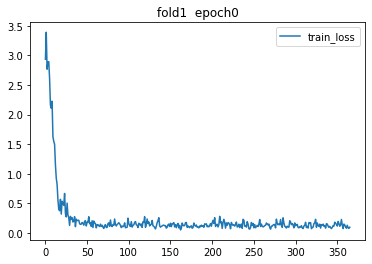

>>> [EVAL] 1/62 [00:00<00:18]   loss: 0.0868(0.0868)
>>> [EVAL] 21/62 [00:06<00:12]   loss: 0.1536(0.1280)
>>> [EVAL] 41/62 [00:12<00:06]   loss: 0.1234(0.1225)


>>> Epoch 1 - avg_train_loss: 0.2288  avg_val_loss: 0.1190  time: 533s
>>> Epoch 1 - score: 0.4891  scores: [0.5449953211270169, 0.4927725582330368, 0.4375501270506976, 0.4807140379178113, 0.5023360638880864, 0.4762793724237409]
>>> 🌟🌟🌟🌟🌟 new best_score: 0.4891


>>> [EVAL] 61/62 [00:18<00:00]   loss: 0.1010(0.1190)
>>> [EVAL] 62/62 [00:18<00:00]   loss: 0.0773(0.1190)




>>> [TRAIN] Epoch 2: 0/366 [00:01<07:15]  loss:0.0675(0.0675);    grad:inf;    lr:0.00000750
>>> [TRAIN] Epoch 2: 20/366 [00:29<08:04]  loss:0.1235(0.1111);    grad:105476.8281;    lr:0.00000724
>>> [TRAIN] Epoch 2: 40/366 [00:57<07:36]  loss:0.0904(0.1143);    grad:126904.8047;    lr:0.00000699
>>> [TRAIN] Epoch 2: 60/366 [01:25<07:08]  loss:0.0901(0.1101);    grad:98824.2891;    lr:0.00000672
>>> [TRAIN] Epoch 2: 80/366 [01:53<06:41]  loss:0.0988(0.1097);    grad:83797.5781;    lr:0.00000645
>>> [TRAIN] Epoch 2: 100/366 [02:22<06:12]  loss:0.0859(0.1093);    grad:84955.9219;    lr:0.00000617
>>> [TRAIN] Epoch 2: 120/366 [02:50<05:44]  loss:0.1075(0.1104);    grad:80274.3047;    lr:0.00000589
>>> [TRAIN] Epoch 2: 140/366 [03:18<05:16]  loss:0.1246(0.1089);    grad:58600.6875;    lr:0.00000561
>>> [TRAIN] Epoch 2: 160/366 [03:46<04:48]  loss:0.0524(0.1090);    grad:80658.5312;    lr:0.00000533
>>> [TRAIN] Epoch 2: 180/366 [04:14<04:20]  loss:0.1059(0.1091);    grad:134937.7500;    lr

In [ ]:
def get_result(oof_df, fold, best_train_loss, best_val_loss):
    labels = oof_df[CFG.target_cols].values
    preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
    score, scores = get_score(labels, preds)
    logger.info(f'Score: {score:<.4f}  Scores: {scores}')
    _output_log = pd.DataFrame([CFG.identifier, CFG.model, CFG.cv_seed, CFG.seed, fold, 'best', score, best_train_loss, best_val_loss] + scores).T
    _output_log.columns = ['file', 'model', 'cv_seed', 'seed', 'fold', 'epoch', 'mcrmse', 'train_loss', 'val_loss'] + CFG.target_cols
    return _output_log

if CFG.train:
    output_log = pd.DataFrame()
    oof_df = pd.DataFrame()
    train_loss_list = []
    val_loss_list = []
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            best_train_loss, best_val_loss, _oof_df, train_history = train_loop(CFG.df_train, fold)
            train_loss_list.append(best_train_loss)
            val_loss_list.append(best_val_loss)
            oof_df = pd.concat([oof_df, _oof_df])
            logger.info(f"========== Fold {fold} result ==========")

            train_history['file'] = CFG.identifier
            train_history['model'] = CFG.model
            train_history['cv_seed'] = CFG.cv_seed
            train_history['seed'] = CFG.seed
            train_history['fold'] = fold
            train_history = train_history[['file', 'model', 'cv_seed', 'seed', 'fold', 'epoch', 'mcrmse', 'train_loss', 'val_loss'] + CFG.target_cols]

            _output_log = get_result(_oof_df, fold, best_train_loss, best_val_loss)
            output_log = pd.concat([output_log, train_history, _output_log])

    oof_df = oof_df.reset_index(drop=True)
    print('\n')
    logger.info(f"========== Out-of-fold result ==========")
    
    _output_log = get_result(oof_df, 'OOF', np.mean(train_loss_list), np.mean(val_loss_list))
    output_log = pd.concat([output_log, _output_log])
    
    output_log.to_csv(os.path.join(CFG.output_dir, f'{CFG.identifier}.csv'), index=False)
    oof_df.to_pickle(os.path.join(CFG.output_dir, 'oof_df.csv'))

In [25]:
get_result(oof_df, fold, best_train_loss, best_val_loss)

Score: 0.4603  Scores: [0.49154900363029463, 0.4508035850468596, 0.41985160436270846, 0.46261502403579335, 0.48686195210368916, 0.45020523765595405]


,file,model,cv_seed,seed,fold,epoch,mcrmse,train_loss,val_loss,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,20221121-173739-roberta-base,roberta-base,42,42,3,best,0.460314,0.092065,0.102648,0.491549,0.450804,0.419852,0.462615,0.486862,0.450205


In [ ]:
!zip -r {CFG.identifier}.zip {CFG.output_dir}